In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.9MB/s eta 0:00:011
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
!pip install gluonts=="0.4.1"

    100% |████████████████████████████████| 327kB 49.0MB/s ta 0:00:01
    100% |████████████████████████████████| 4.8MB 11.4MB/s ta 0:00:011
  Found existing installation: pydantic 1.1.1
    Uninstalling pydantic-1.1.1:
      Successfully uninstalled pydantic-1.1.1
  Found existing installation: gluonts 0.4.2
    Uninstalling gluonts-0.4.2:
      Successfully uninstalled gluonts-0.4.2
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import gluonts
gluonts.__version__

'0.4.1'

In [2]:
import mxnet
mxnet.__version__

'1.4.1'

In [3]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


INFO:root:Using CPU


In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro']


#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [9]:
dataname = "m4_monthly_other"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_other.


In [10]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [11]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([  504.63,   498.05,   497.33,   500.58,   501.12,   503.37,
          508.02,   506.61,   507.22,   506.6 ,   508.77,   515.04,
          506.61,   496.09,   494.82,   496.56,   497.34,   500.15,
          504.55,   502.79,   499.2 ,   501.3 ,   502.51,   497.63,
          491.03,   484.41,   483.62,   484.55,   484.94,   488.75,
          492.16,   493.34,   495.99,   500.32,   504.84,   512.81,
          506.03,   498.41,   500.24,   503.65,   505.43,   509.08,
          513.14,   511.75,   513.22,   515.52,   513.44,   522.57,
          516.35,   510.13,   512.06,   514.89,   517.02,   521.95,
          527.68,   526.  ,   529.1 ,   531.17,   537.75,   549.13,
          542.38,   534.72,   538.3 ,   540.52,   542.73,   549.4 ,
          554.26,   554.27,   558.87,   561.62,   567.86,   577.37,
          571.38,   565.08,   566.96,   570.89,   571.65,   577.61,
          584.07,   581.92,   585.74,   591.37,   59

In [12]:
len(dataset.train)

277

## Plot Series

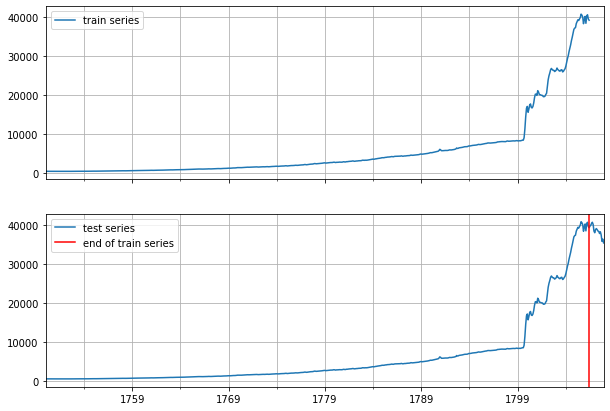

In [13]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [14]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

INFO:root:Using CPU


In [15]:
#########################
### deepstate wrapper ###

data = "m4_monthly_other"
seed = 42
epochs = 1
batches = 1

mx.random.seed(seed)
np.random.seed(seed)

dataset = get_dataset(data)

trainer = Trainer(
    ctx=mx.cpu(0),
#     ctx=mx.gpu(0),
    epochs=epochs,
    num_batches_per_epoch=batches,
    learning_rate=1e-3,
    )

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)

cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
estimator = DeepStateEstimator(
    trainer=trainer,
    cardinality=[cardinality],
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True,
    )

predictor=estimator.train(dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
output["epochs"] = epochs
output["seed"] = seed
output["epochs"] = epochs
output["num_batches"] = batches

pd.DataFrame([output])

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 1/1 [00:01<00:00,  1.87s/it, avg_epoch_loss=0.634]
INFO:root:Epoch[0] Elapsed time 1.879 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.634168
INFO:root:Loading parameters from best epoch (0)
INFO:root:Final loss: 0.6341680884361267 (occurred at epoch 0)
INFO:root:End model training
Running evaluation: 100%|██████████| 277/277 [00:20<00:00, 13.31it/s]


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],epochs,seed,num_batches
0,2.134054,0.209322,22.421174,0.183862,0.13354,1,42,1
